In [1]:
from src.topology.node import Node
from src.protocol import Protocol
from src.message import Message
from src.kernel.timeline import Timeline
from src.components.optical_channel import ClassicalChannel, QuantumChannel
from src.components.detector import PulseDetector
from src.components.light_source import ParametricSource
from src.kernel.event import Event
from src.kernel.process import Process
from enum import Enum, auto
from matplotlib import pyplot as plt
import numpy as np
import numpy.ma as ma
import cupy as cp
from numba import jit
from scipy.fft import fft, ifft

class ExpMsgType(Enum):
    
    STOP = auto()

tl = Timeline(5000e12)

In [2]:
class ExpMsg(Message):

    def __init__(self, msg_type: ExpMsgType, receiver: str, **kwargs):
        super().__init__(msg_type, receiver)

        if msg_type is ExpMsgType.STOP:
            self.distance = kwargs.get("distance")
            self.last_emit_time = kwargs.get("last_emit_time")

In [3]:
# Parameters
# Detector_parameters
collection_probability = 0.8
dark_count_rate = 100
dead_time = 25000
time_resolution = 50

# Optical channel
quantum_channel_attenuation = 0.44
classical_channel_attenuation = 0.5
distance = 2
raman_coefficient = 33e-10
polarization_fidelity = 1
light_speed = 3e8
max_rate = 1e12
quantum_channel_wavelength = 1536e-9
classical_channel_wavelength = 1610e-9

# Light Source
wavelength = quantum_channel_wavelength
mean_photon_num = 0.01
is_distinguishable = True
pulse_separation = 5e3
pulse_width = 80

# Clock parameters
clock_power = 0.0003
narrow_band_filter_bandwidth = 0.03

In [4]:
10e-9

1e-08

In [5]:
class RamanTestSender(Protocol):
    def __init__(self, own: Node):
        self.own = own
        # own.protocols.append(self)
        # self.other_nodes = other_nodes

    def start(self):
        self.own.qchannels[self.own.signal_receiver].start_clock(clock_power, narrow_band_filter_bandwidth)

        for i in range(50):
            last_emit_time = self.emit_event()

        print("last emit time:", last_emit_time)
        distance = self.own.qchannels["signal_receiver"].distance
        new_msg = ExpMsg(ExpMsgType.STOP, self.own.signal_receiver, distance = distance, last_emit_time = last_emit_time)

        process = Process(self.own, "send_message", [self.own.signal_receiver, new_msg])
        event = Event(self.own.timeline.now(), process)
        self.own.timeline.schedule(event)

    def emit_event(self):
        return self.own.parametric_source.schedule_emit()

    def received_message(self, src: str, message: Message):
        pass


class RamanTestReceiver(Protocol):
    def __init__(self, signal_node, idler_node, other_node: str):
        # signal_node.protocols.append(self)
        # idler_node.protocols.append(self)
        self.signal_node = signal_node
        self.idler_node = idler_node
        self.other_node = other_node
        self.first_detection = True
        self.first_detection_time = 0
        self.coincidence_times = []
        self.stop_receiving = False
        self.last_detection = 0

        self.half_hist_bin_width = int(pulse_separation/20)
        self.num_hist_bins_half = 45

        self.signal_buffer = []
        self.idler_buffer = []

    def start(self):
        # start clock and emissions
        pass

    # def trigger(self, receiving_node_detector, time_dict):

    #     if self.stop_receiving:
    #         return
        
    #     detection_time = time_dict['time']
        
    #     # print(f"Received_detection at {detection_time}")

    #     receiving_node = receiving_node_detector.own


    #     if receiving_node == self.signal_node:
    #         self.signal_buffer.append(detection_time)
        
    #     if receiving_node == self.idler_node:
    #         self.idler_buffer.append(detection_time)

        
        # if receiving_node == self.signal_node:
        #     # print("photon received at signal node")
        #     try:
        #         while detection_time -  self.idler_buffer[0] > self.half_hist_bin_width * self.num_hist_bins_half:
        #             del self.idler_buffer[0]
        #     except:
        #         # print("empty idler buffer encountered. ignored")
        #         pass
        #     self.signal_buffer.append(detection_time)
        #     for i in self.idler_buffer:
        #         self.coincidence_times.append(-(detection_time - i))

        #     try:
        #         if detection_time == self.idler_buffer[-1]:
        #             self.coincidence_times.append(0)
        #     except:
        #         pass

        # if receiving_node == self.idler_node:
        #     # print("photon received at idler node")
        #     try:
        #         while detection_time -  self.signal_buffer[0] > self.half_hist_bin_width * self.num_hist_bins_half:
        #             del self.signal_buffer[0]
        #     except:
        #         # print("empty signal buffer encountered. ignored")
        #         pass
        #     self.idler_buffer.append(detection_time)
        #     for i in self.signal_buffer:
        #         self.coincidence_times.append((detection_time - i))

        #     try:
        #         if detection_time == self.signal_buffer[-1]:
        #             self.coincidence_times.append(0)
        #     except:
        #         pass

    
    def received_message(self, src: str, message: Message):
        assert message.msg_type == ExpMsgType.STOP


        distance = message.distance
        last_emit_time = message.last_emit_time

        stop_time = last_emit_time + 5*distance/(3*10**5) * 1e12

        # print("stop time:", stop_time, "distance:", distance)

        process = Process(self, "stop_sim_and_process", [self.half_hist_bin_width * self.num_hist_bins_half])
        event = Event(stop_time, process)
        self.signal_node.timeline.schedule(event)


        

        # self.stop_receiving = True
        # self.get_correlations(self.half_hist_bin_width * self.num_hist_bins_half)
        
        # n, bins, patches = plt.hist(self.coincidence_times, range(-self.half_hist_bin_width * self.num_hist_bins_half, self.half_hist_bin_width * self.num_hist_bins_half, self.half_hist_bin_width))# , range(-28125, 28126, 625)
        # plt.yscale('log')
        # plt.show()
        
        

    def stop_sim_and_process(self, hist_width):
        self.signal_node.timeline.stop()

        # return # Not doing data processing

        print("stopped sim and starting processing")
        
        self.signal_buffer = self.signal_node.detector.log_file
        self.idler_buffer = self.idler_node.detector.log_file
        
        self.signal_dead_time = self.signal_node.detector.dead_time
        self.idler_dead_time = self.idler_node.detector.dead_time
        # print("detector processing step")
        
        prev_signal_detections = np.array([])
        prev_idler_detections = np.array([])

        prev_signal_dead_time = 0
        prev_idler_dead_time = 0

        for i in sorted(map(int, self.signal_buffer)):
            print("sorting window", i)    
            print("length of signal buffer:", len(self.signal_buffer[str(i)][:]), "idler_buffer:", len(self.idler_buffer[str(i)][:]))
            signal_buffer, prev_signal_dead_time = self.sort_remove_dead_counts(self.signal_buffer[str(i)][:], self.signal_dead_time, prev_signal_dead_time)
            idler_buffer, prev_idler_dead_time = self.sort_remove_dead_counts(self.idler_buffer[str(i)][:], self.idler_dead_time, prev_idler_dead_time)
            print("length of dead_time removed signal buffer:", len(self.signal_buffer[str(i)][:]), "idler_buffer:", len(self.idler_buffer[str(i)][:]))
            print("sorted window", i)

            # print("sorted and deadcount removed signal buffer:", signal_buffer)
            # print("sorted and deadcount removed idler buffer:", idler_buffer)

            j_signal = 1
            j_idler = 1
            limit = signal_buffer[-1] - hist_width
            while signal_buffer[-j_signal] > limit:
                j_signal += 1
            while idler_buffer[-j_idler] > limit:
                j_idler += 1

            self.get_correlations(np.append(prev_signal_detections, signal_buffer), np.append(prev_idler_detections, idler_buffer), hist_width, -j_signal, -j_idler)

            print("found correlations for window:", i)

            prev_signal_detections = signal_buffer[-j_signal:]
            prev_idler_detections = idler_buffer[-j_idler:]



        # Uncomment this to turn on correlations again.
        self.get_correlations(prev_signal_detections, prev_idler_detections, hist_width, None, None)

        n, bins, patches = plt.hist(self.coincidence_times, range(-hist_width,hist_width, self.half_hist_bin_width))# , range(-28125, 28126, 625)
        plt.yscale('log')
        plt.show()
            


    def sort_remove_dead_counts(self, pulse_train, dead_time, prev_dead_time):
        
        def GPU_sort(pulse_train):
            GPU_pulse_train = cp.asarray(pulse_train)
            GPU_sorted_pulse_train = cp.sort(GPU_pulse_train)
            return cp.asnumpy(GPU_sorted_pulse_train)

        sorted_pulse_train = GPU_sort(pulse_train)
        # print("done sorting")
        # original_size = len(pulse_train)

        for i in range(len(pulse_train)):
            if pulse_train[i] > prev_dead_time:
                break
        sorted_pulse_train = sorted_pulse_train[i:]

        # print("starting dark count removal")
        
        # kept_detections = np.array([])
        @jit(parallel = True, nopython = True)
        def remove_dark_counts(sorted_pulse_train):
            mask = np.ones(len(sorted_pulse_train))
            i = 0
            while i<=len(sorted_pulse_train)-1:
                mask[i] = 0
                # print("dark count removal:", i, len(sorted_pulse_train))
                j = 1
                while len(sorted_pulse_train) > i+j and sorted_pulse_train[i+j] <= sorted_pulse_train[i] + dead_time:
                    j = j+1
                i = i + j
            return mask

        mask = remove_dark_counts(sorted_pulse_train)
        
        # np.delete(sorted_pulse_train, indices_to_remove)
        sorted_pulse_train = ma.masked_array(sorted_pulse_train, mask = mask)
        out = sorted_pulse_train[~sorted_pulse_train.mask]
        print("done with dark count removal")
        return out, out[-1] + dead_time



    def get_correlations(self, signal_buffer, idler_buffer, hist_width, j_signal, j_idler):
        last_detection_time = 0
        # You iterate over the signal buffer. You look for the idler detections ahead of the present 
        # signal detection which fall inside the hist_width
        for i in signal_buffer[:j_signal]:
            j = last_detection_time
            
            # The last idler detectiuon may be smaller than the present signal detection. So, we need to bring the idler detection to atleast the 
            # present signal detection and we can start counting correlations from there.  
            while j < len(idler_buffer) and idler_buffer[j] < i:
                j += 1

            # We save this for the next signal detection since while iterating over idler detections for this signal detection, we may go over the 
            # ones which could also form correlations with the next signal detection.  
            last_detection_time = j

            # Once your present idler detection >= present signal detection, you can start going ahead in idler detections until the hist_width (ahead
            # of the present signal detection) has been reached. 
            while j < len(idler_buffer) and idler_buffer[j] < i + hist_width:
                self.coincidence_times.append(idler_buffer[j] - i)
                j += 1

        # Very similar for the idler case as in the signal case before this. 
        last_detection_time = 0
        for i in idler_buffer[:j_idler]:
            j = last_detection_time
            while j < len(signal_buffer) and signal_buffer[j] < i:
                j += 1
            last_detection_time = j
            while j < len(signal_buffer) and signal_buffer[j] < i + hist_width:
                # if not i-signal_buffer[j] == 0:
                self.coincidence_times.append(i-signal_buffer[j])
                j += 1

    # def get_correlations(self, signal_buffer, idler_buffer, hist_width, j_signal, j_idler):
        
    #     @jit(parallel = True)
    #     def perform_function(signal_buffer, idler_buffer, j_idler):
    #         out = np.ones(len(signal_buffer))*idler_buffer[0] - signal_buffer
    #         for i in idler_buffer[1 : j_idler]:
    #             out = np.append(out, np.ones(len(signal_buffer))*i - signal_buffer)
    #         return out
        
    #     self.coincidence_times = np.append(self.coincidence_times, perform_function(signal_buffer, idler_buffer, j_idler))
        


        

In [6]:
print(3e8)

300000000.0


In [7]:
class receiver_node(Node):
    def __init__(self, name, timeline, sender_name):
        Node.__init__(self, name, timeline)
        self.detector = PulseDetector(self, name, timeline, collection_probability, dark_count_rate, dead_time, time_resolution)
        self.detector.owner = self
    
    def attach_detector_to_receiver(self, protocol):
        self.detector.attach(protocol)
        self.protocol = protocol

    def receive_message(self, src: str, msg: "Message"):
        self.protocol.received_message(src, msg)

    def receive_qubit(self, src, qubit):
        self.detector.get(qubit)

class sender_node(Node):
    def __init__(self, name, timeline):
        Node.__init__(self, name, timeline)
        self.protocol = RamanTestSender(self)


    def attach_lightsource_to_receivers(self, signal_receiver, idler_receiver):
        self.parametric_source = ParametricSource(self, None, self.timeline, signal_receiver, 
                                                  idler_receiver,wavelength, mean_photon_num, is_distinguishable, pulse_separation, pulse_width)
        self.signal_receiver = signal_receiver
        self.idler_receiver = idler_receiver
        # self.parametric_source.own = self
        # self.spdc_source.attach(self.protocol)

In [8]:
sender = sender_node("sender", tl)
signal_receiver = receiver_node("signal_receiver", tl, 'sender')
idler_receiver = receiver_node("idler_receiver", tl, 'sender')

In [9]:
receiver_protocol = RamanTestReceiver(signal_receiver, idler_receiver, 'sender')

signal_receiver.attach_detector_to_receiver(receiver_protocol)
idler_receiver.attach_detector_to_receiver(receiver_protocol)
sender.attach_lightsource_to_receivers("signal_receiver", "idler_receiver")

In [10]:
import traceback
import sys
try:
    signal_channel = QuantumChannel("signal_channel", tl, quantum_channel_attenuation, classical_channel_attenuation, distance, raman_coefficient, 
                                    polarization_fidelity, light_speed, max_rate, quantum_channel_wavelength, classical_channel_wavelength)
    idler_channel = QuantumChannel("idler_channel", tl, quantum_channel_attenuation, classical_channel_attenuation, distance, raman_coefficient, 
                                    polarization_fidelity, light_speed, max_rate, quantum_channel_wavelength, classical_channel_wavelength)
    classical_channel = ClassicalChannel("classical_channel", tl, distance)
    signal_channel.set_ends(sender, "signal_receiver")
    idler_channel.set_ends(sender, "idler_receiver")
    classical_channel.set_ends(sender, "signal_receiver")
except Exception:
    print(traceback.format_exc())

last emit time: 12700000248920.0
pulse window ID 0
pulse window ID 1
pulse window ID 2
pulse window ID 3
pulse window ID 4
pulse window ID 5
pulse window ID 6
pulse window ID 7
pulse window ID 8
pulse window ID 9
pulse window ID 10
pulse window ID 11
pulse window ID 12
pulse window ID 13
pulse window ID 14
pulse window ID 15
pulse window ID 16
pulse window ID 17
pulse window ID 18
pulse window ID 19
pulse window ID 20
pulse window ID 21
pulse window ID 22
pulse window ID 23
pulse window ID 24
pulse window ID 25
pulse window ID 26
pulse window ID 27
pulse window ID 28
pulse window ID 29
pulse window ID 30
pulse window ID 31
pulse window ID 32
pulse window ID 33
pulse window ID 34
pulse window ID 35
pulse window ID 36
pulse window ID 37
pulse window ID 38
pulse window ID 39
pulse window ID 40
pulse window ID 41
pulse window ID 42
pulse window ID 43
pulse window ID 44
pulse window ID 45
pulse window ID 46
pulse window ID 47
pulse window ID 48
pulse window ID 49
stopped sim and starting pr

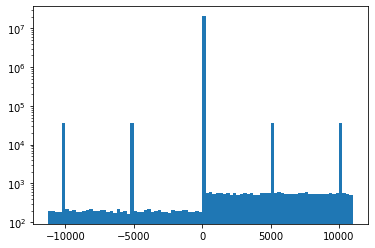

In [11]:
try:
    process = Process(sender.protocol, "start", [])
    event = Event(0, process)
    tl.schedule(event)

    tl.init()
    tl.run()

    # print(signal_receiver.protocol.coincidence_times)
    
    # n, bins, patches = plt.hist(signal_receiver.protocol.detection_times, range(-28125, 28126, 6250))
    # plt.show()    
except Exception:
    print(traceback.format_exc())

In [12]:
np.random.poisson(0.05, (int(100), 1))

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
    

In [13]:
a = []
b  = []
type(np.append(a, b))

numpy.ndarray

In [14]:
import numpy as np
a = np.array([1,2,3,4,5,6,7])
mask = np.array([1,3,5,6])
np.delete(a,mask)

array([1, 3, 5])

In [15]:
import traceback
import h5py
import numpy as np
class try_class:
    def __init__(self):
        self.coincidence_times = []
        
        self.try_file_1 = h5py.File("try_file_1", "w")
        self.try_file_1.create_dataset("0", data = [1,3,6,10,15,20])
        self.try_file_1.create_dataset("1", data = [21,22,25,27,30,33])
        self.try_file_1.create_dataset("2", data = [42,45,46,47,50])

        self.try_file_2 = h5py.File("try_file_2", "w")
        self.try_file_2.create_dataset("0", data = [15,3,12,10,17])
        self.try_file_2.create_dataset("1", data = [24,37,21,30,28,39])
        self.try_file_2.create_dataset("2", data = [52,44,42,56,41])

        self.stop_sim_and_process(5)

    def stop_sim_and_process(self, hist_width):
        # self.signal_node.timeline.stop()
        
        self.signal_buffer = self.try_file_1 # self.signal_node.detector.log_file
        self.idler_buffer = self.try_file_2 # self.idler_node.detector.log_file
        
        self.signal_dead_time = 3 # self.signal_node.detector.dead_time
        self.idler_dead_time = 3 # self.idler_node.detector.dead_time
        # print("detector processing step")
        
        prev_signal_detections = np.array([])
        prev_idler_detections = np.array([])

        prev_signal_dead_time = 0
        prev_idler_dead_time = 0

        for i in sorted(map(int, self.signal_buffer)):
            signal_buffer, prev_signal_dead_time = self.sort_remove_dead_counts(self.signal_buffer[str(i)], self.signal_dead_time, prev_signal_dead_time)
            idler_buffer, prev_idler_dead_time = self.sort_remove_dead_counts(self.idler_buffer[str(i)], self.idler_dead_time, prev_idler_dead_time)

            # print("sorted and deadcount removed signal buffer:", signal_buffer)
            # print("sorted and deadcount removed idler buffer:", idler_buffer)

            j_signal = 1
            j_idler = 1
            limit = signal_buffer[-1] - hist_width
            while signal_buffer[-j_signal] > limit:
                j_signal += 1
            while idler_buffer[-j_idler] > limit:
                j_idler += 1

            self.get_correlations(np.append(prev_signal_detections, signal_buffer), np.append(prev_idler_detections, idler_buffer), hist_width, -j_signal, -j_idler)

            prev_signal_detections = signal_buffer[-j_signal:]
            prev_idler_detections = idler_buffer[-j_idler:]

        # print("remianing detections: ", prev_signal_detections, prev_idler_detections)
        self.get_correlations(prev_signal_detections, prev_idler_detections, hist_width, None, None)
            
            
        # print("signal_buffer:", self.signal_buffer)
        # print("idler_buffer:", self.idler_buffer)
        self.coincidence_times = np.array(self.coincidence_times)
        print(self.coincidence_times[(self.coincidence_times > -hist_width) & (self.coincidence_times < hist_width)])

    def sort_remove_dead_counts(self, pulse_train, dead_time, prev_dead_time):
        sorted_pulse_train = sorted(pulse_train)
        # original_size = len(pulse_train)

        for i in range(len(pulse_train)):
            if pulse_train[i] > prev_dead_time:
                break
        sorted_pulse_train = sorted_pulse_train[i:]

        i = 0

        while i<=len(sorted_pulse_train)-2:
            while len(sorted_pulse_train) >= i+2 and sorted_pulse_train[i+1] <= sorted_pulse_train[i] + dead_time:
                del sorted_pulse_train[i+1]
            i += 1
        return sorted_pulse_train, sorted_pulse_train[-1] + dead_time




    def get_correlations(self, signal_buffer, idler_buffer, hist_width, j_signal, j_idler):
        last_detection_time = 0
        # You iterate over the signal buffer. You look for the idler detections ahead of the present 
        # signal detection which fall inside the hist_width
        for i in signal_buffer[:j_signal]:
            j = last_detection_time
            
            # The last idler detectiuon may be smaller than the present signal detection. So, we need to bring the idler detection to atleast the 
            # present signal detection and we can start counting correlations from there.  
            while j < len(idler_buffer) and idler_buffer[j] < i:
                j += 1

            # We save this for the next signal detection since while iterating over idler detections for this signal detection, we may go over the 
            # ones which could also form correlations with the next signal detection.  
            last_detection_time = j

            # Once your present idler detection >= present signal detection, you can start going ahead in idler detections until the hist_width (ahead
            # of the present signal detection) has been reached. 
            while j < len(idler_buffer) and idler_buffer[j] < i + hist_width:
                self.coincidence_times.append(idler_buffer[j] - i)
                j += 1

        # Very similar for the idler case as in the signal case before this. 
        last_detection_time = 0
        for i in idler_buffer[:j_idler]:
            j = last_detection_time
            while j < len(signal_buffer) and signal_buffer[j] < i:
                j += 1
            last_detection_time = j
            while j < len(signal_buffer) and signal_buffer[j] < i + hist_width:
                self.coincidence_times.append(i-signal_buffer[j])
                j += 1

    def get_correlations2(self, signal_buffer, idler_buffer, hist_width, j_signal, j_idler):
        # if len(signal_buffer) > len(idler_buffer):
        #     main_vector = idler_buffer
        #     iterative_vector = signal_buffer
        # else:
        #     main_vector = signal_buffer
        #     iterative_vector = idler_buffer
        # out = np.array([])
        for i in idler_buffer[: j_idler]:
            self.coincidence_times = np.append(self.coincidence_times, np.ones(len(signal_buffer))*i - signal_buffer)

        # return out




            
try:
    try_class()
except Exception:
    print(traceback.format_exc())


[ 2.  4.  0. -3.  0.  0.  1.  0.  3. -4. -2.  2. -1.]


[ 2. -3.  4.  0.  0. -4.  3. -2. -1.  2.]

In [16]:
idler_buffer = [1,6,10,15,20,25,32,40,42,46,50]
signal_buffer = [3,10,15,21,28,32,37,42,49]
out = np.array([])
for i in idler_buffer:
    np.append(out, np.ones(len(signal_buffer))*i - signal_buffer)

In [17]:
import h5py

f = h5py.File("yoyo", "w")
dset = f.create_dataset("default6", data = [1,2,111111111111,2222222222222])
# dset['default5'] = [99998, 1111]
f.close()


In [18]:
b = f.readline()
print(b)

AttributeError: 'File' object has no attribute 'readline'

In [ ]:
b[1:-2]
# list(map(float, b[1:-2].split(" ")))
b[1:-2].split(" ")

['0.18194267',
 '0.92725176',
 '0.33979624',
 '0.99104974',
 '0.98770235',
 '0.66195912',
 '0.48062318',
 '0.64660168',
 '0.97546594',
 '0.55877476',
 '0.99447907',
 '0.35553081',
 '0.70819528',
 '0.72654763',
 '0.7382016',
 '',
 '0.05726941',
 '0.77239827',
 '0.28973079',
 '0.47466641',
 '0.20259297',
 '0.72928437',
 '0.2383268',
 '',
 '0.99514253',
 '0.4912868',
 '',
 '0.63166395',
 '0.48663553',
 '0.8572449',
 '',
 '0.22881393',
 '0.63110068',
 '0.07251578',
 '0.75225804',
 '0.51032281',
 '0.25353393',
 '0.72717295',
 '0.81458306',
 '0.98383504',
 '0.21604923',
 '0.44058309',
 '0.07749024',
 '0.6014449',
 '',
 '0.24489999',
 '0.04409953',
 '0.8626073',
 '',
 '0.02657677',
 '0.95668916',
 '0.83357231',
 '0.0621107',
 '',
 '0.44778674',
 '0.96147364',
 '0.45705763',
 '0.30871537',
 '0.03673513',
 '0.23289096',
 '0.69193485',
 '0.4387274',
 '',
 '0.28140061',
 '0.13764446',
 '0.53497725',
 '0.49311203',
 '0.07643789',
 '0.80323744',
 '0.64122332',
 '0.73944775',
 '0.46281767',
 '0.2917

In [ ]:
import re
text = "[1,2,3,4] [5,6,7,8]"
pattern = "\[*\]"
ans = re.search(pattern, text)
print(ans)

<re.Match object; span=(8, 9), match=']'>


In [ ]:
class abc:
    def __init__(self, *args):
        print(args)
        print(*args)
abc()

()



In [ ]:
a = [1,2,3,4,5,6,7,8,9]
b = [4,6,7,8,10,12,13,14]
c = [4,7,10,12,15,17,20]
d = [9,11,13,15,17,21,22]

stream = [b,a,d,c]

internal_buffer = []

external_buffer = []

dead_time = 3

for added_batch in stream:
    if len(internal_buffer) == 0:
        internal_buffer.append(added_batch)
        continue
    for j in range(len(internal_buffer)-1, -1, -1):
        if internal_buffer[j][0] > added_batch[0]:
            continue
        else:
            internal_buffer.insert(j+1, added_batch)
            break
    else:
        internal_buffer.insert(0,added_batch)
print(internal_buffer)  





# a.insert(9, 10)
# a

[[1, 2, 3, 4, 5, 6, 7, 8, 9], [4, 6, 7, 8, 10, 12, 13, 14], [4, 7, 10, 12, 15, 17, 20], [9, 11, 13, 15, 17, 21, 22]]


In [ ]:
dark_count_rate = 100
duration = 1000000 * 5080
num_photon_pairs = 0
for i in range(100):
    net_rate = (dark_count_rate/1e12) * duration
    num_photon_pairs = np.random.poisson(lam = net_rate)
    if num_photon_pairs == 0:
        # print("No photons emitted")
        continue
    last_arrival = duration + 1
    while last_arrival > duration:
        last_arrival = np.random.gamma(shape = num_photon_pairs, scale = 1e12/dark_count_rate)  
    
    cur_max = last_arrival
    n = num_photon_pairs-1
    arrival_times = [0]*(n)                  

    for i in range(n,0,-1):
        cur_max = cur_max*np.random.rand()**(1/i)
        arrival_times[i-1] = int(cur_max)
    
    arrival_times = np.append(arrival_times, [int(last_arrival)])

    print(duration-arrival_times)

# arrival_times = np.append(np.random.randint(0, last_arrival, num_photon_pairs-1), [int(last_arrival)]) 

[3.19335278e+09]
[4.53145891e+09]
[7.64520233e+08]
[2.03119966e+09]
[3.36678484e+09]
[4.26014814e+09]
[4.17663056e+09]
[1847062611 1280452544]
[3.58447971e+09]
[2.40527218e+09]
[4.26510132e+09]
[5.376528e+08]
[1.25179293e+09]
[1.2113997e+08]
[4.08177011e+09]
[1.28442057e+09]
[4.62827092e+09]
[2.86049168e+09]
[2.59183802e+09]
[4224305646 2949132299]
[4.41141148e+09]
[2.3759369e+08]
[1.49789636e+09]
[70646044.]
[4731235910 4283691687]
[1.52183502e+09]
[3.72772776e+09]
[3.57526707e+09]
[2.84061479e+09]
[2.96198162e+09]
[4355439844 3932991155]
[1.59509373e+09]
[3.19768955e+09]
[4052035356 1985492282]
[4.12496115e+09]
[2.95035847e+09]
[4817734126 2288041144]


In [ ]:
import cupy as cp
temp
cp.append([], 5 + cp.asarray([5,4,3,2,1]))
# GPU_detection_array = cp.asarray(temp_detector)
GPU_sorted_detection_array = cp.sort(temp_detector)
cp.cuda.runtime.deviceSynchronize()

NameError: name 'temp' is not defined

In [ ]:
try:
    import traceback
    import numpy as np
    import cupy as cp
except Exception:
    print(traceback.format_exc())

In [ ]:
import cupy as cp
import numpy as np
mempool = cp.get_default_memory_pool()

a = np.random.rand(10000000)
print("unsorted a:", a)
a_gpu = cp.asarray(a)
print("sorting now")
a_gpu_sorted = cp.sort(a_gpu)
print("array has been sorted, moving to the nexrt step now")
# cp.cuda.runtime.deviceSynchronize()
a_sorted = cp.asarray(a_gpu_sorted)
print("sorted array:", a_sorted)

unsorted a: [0.99675492 0.25452137 0.96683435 ... 0.13707609 0.14782837 0.65251174]
sorting now
array has been sorted, moving to the nexrt step now
sorted array: [4.40040899e-07 5.42197522e-07 8.76567363e-07 ... 9.99999561e-01
 9.99999831e-01 9.99999970e-01]


In [ ]:
del a_gpu
# del a_gpu_sorted


mempool.free_all_blocks()
mempool.used_bytes()

NameError: name 'a_gpu' is not defined

In [ ]:
mempool.used_bytes()

1600000000